# Analiza koszykowa i rekomendacja produktów
Celem notebooka jest zaprezentowanie jak analiza koszykowa umożliwia rekomendację produktów w celu wsparcia sprzedaży.

In [1]:
# importujemy potrzebne biblioteki
from os.path import pardir, join

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from IPython.display import display

sns.set_palette("Blues")
apriori_dict = {
    'antecedents': 'poprzednicy',
    'consequents': 'następnicy',
    'antecedent support': 'wsparcie poprzedników',
    'consequent support': 'wsparcie następników',
    'support': 'wsparcie',
    'confidence': 'pewność',
    'lift': 'przyrost',
    'leverage': 'dźwignia',
    'conviction': 'przekonanie'
}

-------
### Instrukcja uzupełniania
Miejsca gdzie należy napisać/uzupełnić kod znajdują się bezpośrednio **pod** komentarzami z tagiem `todo`.

Przykład:
```python
a = some_function()
# todo: stwórz nową zmienną z napisem 'zmienna'
b = ...
# todo: wypisz zmienną b
```

Rozwiązanie:
```python
a = some_function()
# todo: stwórz nową zmienną z napisem 'zmienna'
b = 'zmienna'
# todo: wypisz zmienną b
print(b)
```

Jeśli wymagane jest odpowiednie nazewnictwo zmiennych będą one zadeklarowane z przypisanym operatorem ```...``` (tak jak jest to pokazane powyżej).

Jeśli nie uda Ci się wykonać zadań opisanych w `todo`, na samym dole notebooka znajduje się ściąga pozwalająca uzupełnić brakujące linijki i kontynuować wasztat. Korzystamy z nich dopiero w ostateczności :)

---------
### Cheat Sheet:
1. Ładowanie danych do  tabeli DataFrame z pliku *.csv*:
```python
df = pd.read_csv('ścieżka_do_pliku.csv')
```
2. Wyświetl `n` pierwszych wierszy tabeli DataFrame (`n` domyślnie równe 5):
    - jeśli to ostatnia komenda w komórce:
```python
df.head(n)
```
    - jeśli tak nie jest:
```python
display(df.head(n))
```
3. Obrót tabeli DataFrame (tzw. *pivot*) sumujący wartości z ```kolumna_do_zliczenia``` we wszystkich kombinacjach ```kolumna_x``` z ```kolumna_y```.
```python
df = pd.pivot_table(df, values='kolumna_do_zliczania', index='kolumna_x', columns='kolumna_y', aggfunc=np.sum)
```
4. Podmiana wszystkich wartości ```NaN``` (*Not a Number*) na wybraną wartość:
```python 
df = df.fillna(wartość_do_podmiany)
```
5. Sortowanie malejące wierszy w tabeli DataFrame według wartości w kolumnie/kolumnach:
 - dla jednej kolumny
```python
df = df.sort_values('kolumna', ascending=False)
```
 - dla wielu kolumn
```python
df = df.sort_values(['kolumna_1', 'kolumna_2'], ascending=False)
```
6. Usuwanie duplikatów wierszy na podstawie wartości w kolumnie:
```python
df = df.drop_duplicates('nazwa_kolumny', keep='first')
```

-------
### Część I  - Wyznaczenie reguł
#### Ładowanie i wizualizacja danych

In [2]:
# wyznaczamy ścieżkę do pliku z danymi
data_dir = join(pardir, 'data')
filepath = join(data_dir, 'dane_analiza_koszykowa.csv')

### 1) todo:
- Załaduj plik z danymi do tabeli DataFrame (ścieżka w zmiennej `filepath`)
- Wyświetl kilka pierwszych wierszy tabeli

In [4]:
# todo: wczytaj dane do zmiennej df
df = pd.read_csv(filepath)
# todo: wyświetl kilka pierwszych wierszy tabeli
df.head()

,receipt_id,product_id,product_category,product_subcategory,product_name,quantity
0,1,54,Pieczywo,Bułka,Ciabatka,5
1,3,54,Pieczywo,Bułka,Ciabatka,5
2,7,54,Pieczywo,Bułka,Ciabatka,5
3,10,54,Pieczywo,Bułka,Ciabatka,6
4,11,54,Pieczywo,Bułka,Ciabatka,8


In [5]:
def show_countplot(df, variable_name, description=None):
    """Pokazuje top 10 najlepiej sprzedających się produktów/kategorii."""
    assert variable_name in df.columns, "Kolumna nie zawiera się w tabeli, wybierz inną kolumnę."
    sns.countplot(x=variable_name, data=df, order=df[variable_name].value_counts().iloc[:10].index)
    plt.xticks(rotation=90)
    if description:
        plt.title(description)
    plt.show()

### 2) todo:
- Używając funkcji ```show_countplot``` wyświetl najlepiej sprzedające się:
    - produkty (kolumna`product_name`)
    - podkategorie produktów (kolumna `product_subcategory`)
    - kategorie produtów (kolumna `product_category`)

Najlepiej sprzedające się produkty na poziomie product_name:


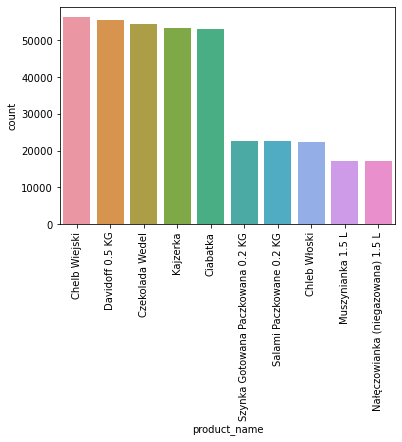

Najlepiej sprzedające się produkty na poziomie product_subcategory:


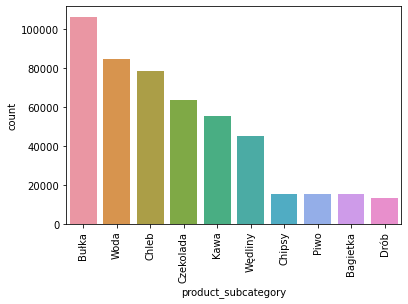

Najlepiej sprzedające się produkty na poziomie product_category:


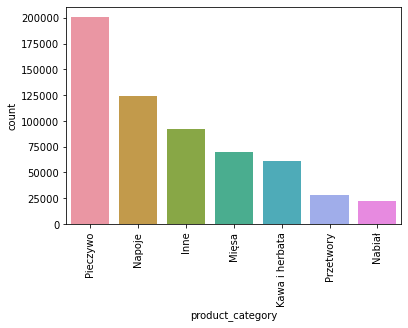

In [7]:
# todo: zapełnij tuple modelling_columns nazwami kolumn odpowiadających za poszczególne poziomy grupowania 
# produktów: (produkty, podkategorie, kategorie)
modelling_columns = ('product_name','product_subcategory','product_category')
for column_name in modelling_columns:
    print(f'Najlepiej sprzedające się produkty na poziomie {column_name}:')
    # todo: wyświetl wykres
    show_countplot(df,column_name)

#### Wyznaczanie reguł asocjacyjnych
Aby znaleźć grupy produktów czesto kupowanych razem oraz reguły asocjacyjne (np.: *jeśli kupię chleb to kupię też masło z pewnością 70%*) potrzebujemy specjalnie przygotowanej tabeli.

Aby ją przygotować należy przekształcić dotychczasową tabelę przy pomocy funkcji ```pd.pivot_table```. Wyjściowa macierz będzie miałą poszczególne paragony (koszyki) jako indeksy (oś Y), poszczególne produkty jako kolumny (oś X), a jej wartości będą reprezentować liczbę kolejnych rodzajów produktów w kolejnych koszykach.

Przykładowa tabela wejściowa:

| Paragon   | Produkt   | Liczba |
|-----------|-----------|--------|
| Paragon_1 | Produkt_1 | 1      |
| Paragon_2 | Produkt_2 | 2      |
| Paragon_2 | Produkt_3 | 1      |
| Paragon_3 | Produkt_1 | 2      |
| Paragon_3 | Produkt_2 | 5      |

Po wywołaniu na niej funkcji
```python
pd.pivot_table(tabela, values='Liczba', index='Paragon', columns='Produkt', aggfunc=np.sum)
```
będzie wyglądać następująco:

|          | Produkt_1 | Produkt_2 | Produkt_3 |
|-----------|-----------|-----------|-----------|
| Paragon_1 | 1         | Nan       | Nan       |
| Paragon_2 | NaN       | 2         | 1         |
| Paragon_3 | 2         | 5         | Nan       |

### 3) todo 
- Przekształć tabelę przy pomocy ```pd.pivot_table``` na podstawie powyższego przykładu:
    - chcemy zliczyć występowania produktów (`quantity`)
    - w poszczególnych koszykach (`receipt_id`)
    - pogrupowane według rodzajów produktów (kolumna odpowiadająca wybranemu poziomowi modelowania, zmienna `modelling_variable`)
- W przekształconej tabeli zapełnij pola ```NaN``` zerami

In [8]:
# wypiszmy kolumny, które odpowiadają kolejnym poziomom modelowania
print(f'Istnieją {len(modelling_columns)} kolumny odpowiadające kolejnym poziomom modelowania:')
for colname in modelling_columns:
    print(f'- {colname}')

Istnieją 3 kolumny odpowiadające kolejnym poziomom modelowania:
- product_name
- product_subcategory
- product_category


In [9]:
# todo: wybierz zmienną określającą poziom modelowania (jedna z wylistowanych powyżej)
modelling_variable = 'product_name'
# sprawdźmy czy dana zmienna istnieje w tabeli 
assert modelling_variable in df.columns, "Kolumna nie zawiera się w tabeli, wybierz inną kolumnę."

In [11]:
# todo: obróć tabelę przy pomocy pd.pivot_table
# hint: jako wartość parametru columns ustaw zmienną modelling_variable
basket = pd.pivot_table(df, values='quantity', index='receipt_id', columns=modelling_variable, aggfunc=np.sum)
# todo: wyświetl kilka pierwszych wierszy z tabeli basket
basket.head()

product_name,Absolut Kurant 0.7 L,Aspiryna 10 saszetek,Bagietka Francuska,Bordeaux 2012,Carlsberg (butelka) 0.5 L,Carlsberg (puszka) 0.5 L,Chelb Wiejski,Chipsy Cheetos Czosnkowe 0.1 KG,Chipsy Lays Cebulowe 0.1 KG,Chleb Włoski,...,Szynka Gotowana Paczkowana 0.2 KG,Tokaji Aszu 3 puttonyos,Tyskie (butelka) 0.5 L,Tyskie (puszka) 0.5 L,Udziec Wieprzowy 0.5 KG,Łomża (butelka) 0.5 L,Żubrówka Biała 0.5 L,Żubrówka Biała 100 mL,Żywiec Zdrój (gazowana) 1.5 L,Żywiec Zdrój (niegazowana) 1.5 L
receipt_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# todo: zapełnij pola NaN tabeli basket zerami
basket = basket.fillna(0)
# zmieniamy wartości w tabeli zliczeniowej na binarne:
#  - 1 oznacza, że produkt występował w danym koszyku
#  - 0 oznacza,że nie występował
basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)
basket_sets.head()

product_name,Absolut Kurant 0.7 L,Aspiryna 10 saszetek,Bagietka Francuska,Bordeaux 2012,Carlsberg (butelka) 0.5 L,Carlsberg (puszka) 0.5 L,Chelb Wiejski,Chipsy Cheetos Czosnkowe 0.1 KG,Chipsy Lays Cebulowe 0.1 KG,Chleb Włoski,...,Szynka Gotowana Paczkowana 0.2 KG,Tokaji Aszu 3 puttonyos,Tyskie (butelka) 0.5 L,Tyskie (puszka) 0.5 L,Udziec Wieprzowy 0.5 KG,Łomża (butelka) 0.5 L,Żubrówka Biała 0.5 L,Żubrówka Biała 100 mL,Żywiec Zdrój (gazowana) 1.5 L,Żywiec Zdrój (niegazowana) 1.5 L
receipt_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# wyznaczamy często występujące grupy produktów (występujące w przynamniej 1% koszyków)
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
# na podstawie grup wyznaczamy reguły asocjacyjne
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0).rename(columns=apriori_dict)
print('Tabela z regułami zawiera następujące kolumny:')
for colname in rules.columns:
    print(f'- {colname}')
rules.head()

Tabela z regułami zawiera następujące kolumny:
- poprzednicy
- następnicy
- wsparcie poprzedników
- wsparcie następników
- wsparcie
- pewność
- przyrost
- dźwignia
- przekonanie


,poprzednicy,następnicy,wsparcie poprzedników,wsparcie następników,wsparcie,pewność,przyrost,dźwignia,przekonanie
0,(Bagietka Francuska),(Chelb Wiejski),0.070401,0.256290,0.022364,0.317668,1.239489,0.004321,1.089954
1,(Chelb Wiejski),(Bagietka Francuska),0.256290,0.070401,0.022364,0.087261,1.239489,0.004321,1.018472
2,(Ciabatka),(Bagietka Francuska),0.241724,0.070401,0.020937,0.086616,1.230321,0.003920,1.017752
3,(Bagietka Francuska),(Ciabatka),0.070401,0.241724,0.020937,0.297398,1.230321,0.003920,1.079240
4,(Kajzerka),(Bagietka Francuska),0.242133,0.070401,0.020996,0.086713,1.231709,0.003950,1.017861


In [15]:
# todo: posortuj zbiór według pewności reguły
rules = rules.sort_values('pewność', ascending=False)
# todo: wyświetl kilka pierwszych reguł z tabeli rules
rules.head(10)

,poprzednicy,następnicy,wsparcie poprzedników,wsparcie następników,wsparcie,pewność,przyrost,dźwignia,przekonanie
71,(Czekolada Wedel),(Davidoff 0.5 KG),0.247755,0.252895,0.227727,0.919161,3.634558,0.165071,9.241929
70,(Davidoff 0.5 KG),(Czekolada Wedel),0.252895,0.247755,0.227727,0.900480,3.634558,0.165071,7.558718
6,(Chipsy Cheetos Czosnkowe 0.1 KG),(Chelb Wiejski),0.034912,0.256290,0.011366,0.325566,1.270305,0.002419,1.102718
17,(Muszynianka 1.5 L),(Chelb Wiejski),0.077627,0.256290,0.025059,0.322815,1.259570,0.005164,1.098238
26,(Skrzydełka Kurczaka 0.25 KG),(Chelb Wiejski),0.034875,0.256290,0.011252,0.322648,1.258918,0.002314,1.097967
11,(Chleb Włoski),(Chelb Wiejski),0.101959,0.256290,0.032676,0.320481,1.250465,0.006545,1.094466
0,(Bagietka Francuska),(Chelb Wiejski),0.070401,0.256290,0.022364,0.317668,1.239489,0.004321,1.089954
22,(Piątnica Twaróg Wiejski 0.25 KG),(Chelb Wiejski),0.051541,0.256290,0.016361,0.317432,1.238568,0.003151,1.089577
30,(Żywiec Zdrój (gazowana) 1.5 L),(Chelb Wiejski),0.076595,0.256290,0.024309,0.317373,1.238336,0.004679,1.089482
32,(Żywiec Zdrój (niegazowana) 1.5 L),(Chelb Wiejski),0.076404,0.256290,0.024223,0.317035,1.237020,0.004641,1.088944


### 4) todo:
Wróć do punktu **3) todo** i sprawdź jakie reguły generowane są dla innych poziomów modelowania (kolumny: `product_name`, `product_subcategory`, `product_category`). Oceń przydatność biznesową reguł i wybierz kolumnę będącą "*złotym środekiem*", czyli kompromisem pomiędzy szczegółowością a pewnością.

Po wyborze odpowiedniej zmiennej (odpowiadającej poziomowi modelowania) ponownie uruchom komórki od sekcji **3) todo**. W ten sposób zmienna `rules` zawierać będzie odpowiednie reugły.

In [17]:
# todo: wybierz zmienną określającą poziom modelowania (jedna z wylistowanych powyżej)
modelling_variable = 'product_subcategory'
# sprawdźmy czy dana zmienna istnieje w tabeli 
assert modelling_variable in df.columns, "Kolumna nie zawiera się w tabeli, wybierz inną kolumnę."

# todo: obróć tabelę przy pomocy pd.pivot_table
# hint: jako wartość parametru columns ustaw zmienną modelling_variable
basket = pd.pivot_table(df, values='quantity', index='receipt_id', columns=modelling_variable, aggfunc=np.sum)
# todo: wyświetl kilka pierwszych wierszy z tabeli basket
basket.head()

# todo: zapełnij pola NaN tabeli basket zerami
basket = basket.fillna(0)
# zmieniamy wartości w tabeli zliczeniowej na binarne:
#  - 1 oznacza, że produkt występował w danym koszyku
#  - 0 oznacza,że nie występował
basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)
basket_sets.head()

# wyznaczamy często występujące grupy produktów (występujące w przynamniej 1% koszyków)
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)
# na podstawie grup wyznaczamy reguły asocjacyjne
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0).rename(columns=apriori_dict)
print('Tabela z regułami zawiera następujące kolumny:')
for colname in rules.columns:
    print(f'- {colname}')
rules.head()

# todo: posortuj zbiór według pewności reguły
rules = rules.sort_values('pewność', ascending=False)
# todo: wyświetl kilka pierwszych reguł z tabeli rules
rules.head(10)

Tabela z regułami zawiera następujące kolumny:
- poprzednicy
- następnicy
- wsparcie poprzedników
- wsparcie następników
- wsparcie
- pewność
- przyrost
- dźwignia
- przekonanie


,poprzednicy,następnicy,wsparcie poprzedników,wsparcie następników,wsparcie,pewność,przyrost,dźwignia,przekonanie
88,(Kawa),(Czekolada),0.252895,0.287829,0.229154,0.906123,3.148123,0.156363,7.586170
89,(Czekolada),(Kawa),0.287829,0.252895,0.229154,0.796144,3.148123,0.156363,3.664871
22,(Majonez),(Bułka),0.025464,0.411575,0.013248,0.520257,1.264063,0.002767,1.226542
41,(Wódka),(Bułka),0.025468,0.411575,0.013161,0.516774,1.255600,0.002679,1.217700
211,"(Woda, Czekolada)",(Bułka),0.023573,0.411575,0.012125,0.514363,1.249742,0.002423,1.211655
20,(Lody),(Bułka),0.026436,0.411575,0.013575,0.513495,1.247633,0.002694,1.209494
169,"(Drób, Chleb)",(Bułka),0.024527,0.411575,0.012580,0.512878,1.246133,0.002485,1.207961
215,"(Drób, Woda)",(Bułka),0.023623,0.411575,0.012102,0.512312,1.244760,0.002380,1.206561
14,(Drób),(Bułka),0.060075,0.411575,0.030758,0.511990,1.243978,0.006032,1.205765
165,"(Chleb, Czekolada)",(Bułka),0.024373,0.411575,0.012430,0.509976,1.239083,0.002398,1.200808


----------
### Część II  - Rekomendacja produktów
Sprawdźmy jakie produkty można zarekomendować klientowi o identyfikatorze paragonu ```2```

In [18]:
# wybierzmy część tabeli odpowiadającej koszykowi o id 229822
basket_id = 229822
receipt = df[df['receipt_id'] == basket_id]
# utwórzmy zbiór zawierający produkty z koszyka o id 2
basket_items = set(receipt[modelling_variable].values)
print(f'Koszyk o id: {basket_id} zawiera następujące produkty: {basket_items}')

Koszyk o id: 229822 zawiera następujące produkty: {'Bułka', 'Kawa'}


#### Filtrowanie reguł
Nie wszystkie reguły, które wygenerowaliśmy przydadzą nam się w rekomendacji. Potrzebujemy reguł, które spełniają następujące warunki:
1. zbiór *poprzedników* reguły posiada produkty wspólne ze zbiorem produktów koszyka
2. zbiór *następników* reguły nie ma produktów wspólnych ze zbiorem produktów koszyka

Aby odfiltrować nieprzydatne reguły potrzebujemy funkcji:
1. wyznaczającej podobieństwo poszczególnych *poprzedników* reguł do zawartości koszyka,
2. odfiltrowjącej reguły, których *następnicy* znajdują się w koszyku.

Z racji, iż koszyk reprezentowany jest jako zbiór produktów, do obliczania podobieństwa użyjemy indeksu Jaccarda. Jest to miara podobieństwa zbiorów w zakresie [0, 1]:
![alt text](../data/jaccard.PNG)
 źródło: https://en.wikipedia.org/wiki/Jaccard_index

In [19]:
# do spełnienia warunku 1. użyjemy funkcji obliczającej podobieństwa Jaccarda
# umożliwi nam ona sortowanie reguł według podobieństwa ich poprzedników do koszyka
def jaccard_similarity(x, y):
    x, y = set(x), set(y)
    return len(x.intersection(y)) / len(x.union(y))

# do spełnienia warunku 2. użyjemy funkcji sprawdzającej wielkość części wspólnej
# następników i koszyka
def intersects_with_basket(x, y):
    x = set(x['następnicy'])
    return len(x.intersection(y)) == 0

### 5) todo:
- Dodaj do tabeli reguł ```rules``` nową kolumnę zawierającą wartość podobieństwa Jaccarda pomiędzy zbiorem produktów (zmienna ```basket_items```) w przykładowym koszyku, a poszczególnymi *poprzednikami* dla każdej z reguł.

Aby dodać do tabeli nową kolumnę, która liczona jest na podstawie innej użyjemy kombinacji funkcji `apply` i `lambda`. Aby obliczyć podobieństwo nalezy:
- użyć kolumny `poprzednicy` jako bazy do obliczeń
- funkcji `jaccard_similarity` jako funkcji (zastępuje `moja_funkcja`)
- jako argumentów funkcji `jaccard_similarity` użyć:
    - wartości z kolumny `poprzednicy`
    - zbioru elementów koszyka `basket_items`


```python
# przykład użycia apply + lambda
rules['nowa_kolumna'] = rules['kolumna_X'].apply(lambda element_kolumny_X: moja_funkcja(element_kolumny_X))

# przykład tworzący nową kolumnę z długością zbioru poprzednich
rules['nowa_kolumna'] = rules['poprzednicy'].apply(lambda x: len(x))
```

In [20]:
# todo: dodaj kolumnę zawierającą podobieństwo poprzedników reguły do koszyka
rules['podobieństwo'] = rules['poprzednicy'].apply(lambda x: jaccard_similarity(x,basket_items))
# usuń reguły o następnikach występujących już w koszyku
rules = rules[rules.apply(lambda x: intersects_with_basket(x, basket_items), axis=1)]

### 6) todo:
- Odfiltruj wiersze z  zerowym podobieństwem (```rules[reguła]``` czyli np. ```rules[rules['wybrana_kolumna'] > 5]```)
- Posortuj wartości malejąco używając do tego kolumn odpowiadających:
    1. podobieństwu Jaccarda *poprzedników* reguły do zawartości analizowanego koszyka 
    2. pewności reguły
- Odrzuć wszystkie kolumny oprócz kolumn: ```następnicy``` i ```pewność```
- Usuń duplikaty tak aby dla każdego następnika zachować regułę o najwyższej pewności


In [23]:
# todo: odfiltruj reguły o zerowym podobieństwie do koszyka
recommendations = rules[rules['podobieństwo']>0]
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

,poprzednicy,następnicy,wsparcie poprzedników,wsparcie następników,wsparcie,pewność,przyrost,dźwignia,przekonanie,podobieństwo
88,(Kawa),(Czekolada),0.252895,0.287829,0.229154,0.906123,3.148123,0.156363,7.586170,0.500000
168,"(Drób, Bułka)",(Chleb),0.030758,0.325573,0.012580,0.408983,1.256197,0.002566,1.141131,0.333333
128,"(Bułka, Bagietka)",(Chleb),0.035621,0.325573,0.014384,0.403802,1.240282,0.002787,1.131214,0.333333
176,"(Bułka, Piwo)",(Chleb),0.033989,0.325573,0.013648,0.401524,1.233286,0.002582,1.126908,0.333333
199,"(Bułka, Śmietana)",(Chleb),0.025336,0.325573,0.010166,0.401256,1.232461,0.001918,1.126403,0.333333


In [25]:
# todo: posortuj reguły malejąco według podobieństwa i pewności
recommendations = recommendations.sort_values(['podobieństwo','pewność'], ascending=False)
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

,poprzednicy,następnicy,wsparcie poprzedników,wsparcie następników,wsparcie,pewność,przyrost,dźwignia,przekonanie,podobieństwo
88,(Kawa),(Czekolada),0.252895,0.287829,0.229154,0.906123,3.148123,0.156363,7.586170,0.5
10,(Bułka),(Chleb),0.411575,0.325573,0.164525,0.399744,1.227818,0.030527,1.123566,0.5
38,(Bułka),(Woda),0.411575,0.318406,0.160721,0.390502,1.226428,0.029673,1.118287,0.5
43,(Bułka),(Wędliny),0.411575,0.192779,0.097650,0.237260,1.230740,0.018308,1.058318,0.5
189,(Bułka),"(Chleb, Woda)",0.411575,0.127618,0.064161,0.155891,1.221551,0.011637,1.033495,0.5


In [26]:
# todo: odrzuć wszystkie kolumny oprócz następników, pewności i przyrostu
columns_to_keep = ['następnicy','pewność','przyrost']
recommendations = recommendations[columns_to_keep]
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

,następnicy,pewność,przyrost
88,(Czekolada),0.906123,3.148123
10,(Chleb),0.399744,1.227818
38,(Woda),0.390502,1.226428
43,(Wędliny),0.237260,1.230740
189,"(Chleb, Woda)",0.155891,1.221551


In [27]:
# todo: usuń duplikaty zachowując reguły o największej pewności
recommendations = recommendations.drop_duplicates('następnicy', keep='first')
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

,następnicy,pewność,przyrost
88,(Czekolada),0.906123,3.148123
10,(Chleb),0.399744,1.227818
38,(Woda),0.390502,1.226428
43,(Wędliny),0.237260,1.230740
189,"(Chleb, Woda)",0.155891,1.221551


In [28]:
recommendations_display = pd.DataFrame()
recommendations_display['Rekomendowane produkty'] = recommendations['następnicy'].apply(lambda x: ', '.join([x for x in iter(x)]))
recommendations_display['Pewność rekomendacji (%)'] = recommendations['pewność'].apply(lambda x: str(round(100 * x, 2)) + '%')
recommendations_display['Przyrost'] = recommendations['przyrost']
print(f"Wiedząc, że klient kupił {', '.join(list(basket_items))}")
recommendations_display.reset_index().drop(columns=['index']).head(10)

Wiedząc, że klient kupił Bułka, Kawa


,Rekomendowane produkty,Pewność rekomendacji (%),Przyrost
0,Czekolada,90.61%,3.148123
1,Chleb,39.97%,1.227818
2,Woda,39.05%,1.226428
3,Wędliny,23.73%,1.230740
4,"Chleb, Woda",15.59%,1.221551
5,"Wędliny, Chleb",9.45%,1.232126
6,"Wędliny, Woda",9.25%,1.232270
7,Bagietka,8.65%,1.229353
8,Chipsy,8.55%,1.238358
9,Piwo,8.26%,1.211040


### Rozwiązanie:

1.
```python
# todo: wczytaj dane do zmiennej df
df = pd.read_csv(filepath)
# todo: wyświetl kilka pierwszych wierszy tabeli
df.head()
```

2.
```python
modelling_columns = ('product_name', 'product_subcategory', 'product_category')
for column_name in modelling_columns:
    print(f'Najlepiej sprzedające się produkty na poziomie {column_name}:')
    # todo: wyświetl wykres
    show_countplot(df, column_name)
```

3.
```python
# todo: obróć tabelę przy pomocy pd.pivot_table
basket = pd.pivot_table(df, values='quantity', index='receipt_id', columns=modelling_variable, aggfunc=np.sum)
# todo: wyświetl kilka pierwszych wierszy z tabeli basket
basket.head()

# todo: zapełnij pola NaN tabeli basket zerami
basket = basket.fillna(0)
# zmieniamy wartości w tabeli zliczeniowej na binarne:
#  - 1 oznacza, że produkt występował w danym koszyku
#  - 0 oznacza,że nie występował
basket_sets = basket.applymap(lambda x: 1 if x >= 1 else 0)
basket_sets.head()

# todo: posortuj zbiór według pewności reguły
rules = rules.sort_values('pewność', ascending=False)
# todo: wyświetl kilka pierwszych reguł z tabeli rules
rules.head()

```

4.
Pod sekcją **3) todo** należy przypisać do zmiennej `modelling_variable` jedną z trzech możliwych wartości:
- ```python
modelling_variable = 'product_name'
```

- ```python
# ta zmienna zapewnia wspomniany "złoty środek"
modelling_variable = 'product_subcategory'
```

- ```python
modelling_variable = 'product_category'
```

 Następnie należy uruchomić komórki z kodem aż do **5) todo**.


5.
```python
rules['podobieństwo'] = rules['poprzednicy'].apply(lambda x: jaccard_similarity(x, basket_items))

```
6.
```python
# todo: odfiltruj reguły o zerowym podobieństwie do koszyka
recommendations = rules[rules['podobieństwo'] > 0]
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

# todo: posortuj reguły malejąco według podobieństwa i pewności
recommendations = recommendations.sort_values(['podobieństwo', 'pewność'], ascending=False)
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

# todo: odrzuć wszystkie kolumny oprócz następników, pewności i przyrostu
columns_to_keep = ['następnicy', 'pewność', 'przyrost']
recommendations = recommendations[columns_to_keep]
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()

# todo: usuń duplikaty zachowując reguły o największej pewności
recommendations = recommendations.drop_duplicates('następnicy', keep='first')
# todo: wyświetl kilka pierwszych wierszy tabeli
recommendations.head()
```
